In [1]:
import os
import time
import warnings
import numpy as np
import random as rnd
import pandas as pd
from collections import defaultdict

# Librería Genética
from deap import base, creator, tools, algorithms

from sklearn.utils import shuffle
# Subfunciones de estimadores
from sklearn.base import clone
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][30]
from sklearn.base import is_classifier
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][535]
from sklearn.model_selection._validation import _fit_and_score
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py][346]
from sklearn.model_selection._search import BaseSearchCV
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][386]
from sklearn.model_selection._search import check_cv
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py][1866]
from sklearn.model_selection._search import _check_param_grid
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][343]
from sklearn.metrics.scorer import check_scoring
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/scorer.py][250]
from sklearn.utils.validation import _num_samples
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][105]
from sklearn.utils.validation import indexable
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][208]
from multiprocessing import Pool, Manager, cpu_count

# Selección para estimadores
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metricas para estimadores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Estimadores
from sklearn.ensemble import ExtraTreesClassifier#
from sklearn.ensemble import RandomForestClassifier#
from sklearn.ensemble import AdaBoostClassifier#
from sklearn.ensemble import GradientBoostingClassifier#
from sklearn.tree import DecisionTreeClassifier#
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

"""
PYMACH
"""
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer

#Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Ensembles algorithms
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# find distance error al 0.2%
def distance_error(estimator, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    # coord pred
    x1 = np.int32((y_pred + 2) % 3)
    y1 = np.int32((y_pred - 1) / 3)
    # coord real
    x2 = np.int32((y_test + 2) % 3)
    y2 = np.int32((y_test - 1) / 3)
    # pasar variacion a distancias metros
    vx = np.abs(x1 - x2)*1.5
    vy = np.abs(y1 - y2)*1.5
    #vx = vx*0.5 + (vx-1)*(vx>0)
    #vy = vy*0.5 + (vy-1)*(vy>0)
    # pitagoras
    err_distance = np.sqrt(vx*vx + vy*vy)
    return err_distance

def _createDataset(frecuencias, values, seed = 7):
    # crear dataset
    names_ = frecuencias[0].columns.values
    # reestructuracion
    salida_final = pd.DataFrame(columns=names_)
    for sec in range(1,16):
        dataset = pd.DataFrame(columns=names_)
        corte = min([frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values])
        tx = 0
        dataset[names_[tx]] = dataset[names_[tx]].append(frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]])
        dataset = dataset.reset_index(drop=True)
        for tx in range(1,5):
            dataset[names_[tx]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]].reset_index()
        dataset[names_[tx+1]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx+1]].reset_index()
        # join parts
        salida_final = salida_final.append(dataset)
    # shuffle dataset
    salida_final = shuffle(salida_final, random_state=seed).reset_index(drop=True)
    salida_final = salida_final.apply(pd.to_numeric)
    # dataframe to X,y 
    X = salida_final[names_[:-1]]
    y = salida_final[names_[-1]]
    return X,y

def _individual_to_params(frecuencias, values):
    # crear dataset
    names_ = frecuencias[0].columns.values
    seed = 7
    # reestructuracion
    salida_final = pd.DataFrame(columns=names_)
    for sec in range(1,16):
        dataset = pd.DataFrame(columns=names_)
        corte = min([frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values])
        #l = [frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values]
        #corte = max(l)
        #tx=l.index(max(l))
        tx = 0
        dataset[names_[tx]] = dataset[names_[tx]].append(frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]])
        dataset = dataset.reset_index(drop=True)
        for tx in range(1,5):
            dataset[names_[tx]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]].reset_index(drop=True)
        dataset[names_[tx+1]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx+1]].reset_index(drop=True)
        # join parts
        salida_final = salida_final.append(dataset)
    # shuffle dataset
    salida_final = shuffle(salida_final, random_state=seed).reset_index(drop=True)
    salida_final = salida_final.apply(pd.to_numeric)
    # dataframe to X,y 
    X = salida_final[names_[:-1]]
    y = salida_final[names_[-1]]
    return X,y

def set_models():
    rs = 1
    models = []
    # LDA : Warning(Variables are collinear)
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    #"""
    models.append(('SVC', SVC(random_state=rs)))
    models.append(('GaussianNB', GaussianNB()))
    models.append(('MLPClassifier', MLPClassifier()))
    #"""
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    #"""
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs)))
    models.append(('LogisticRegression', LogisticRegression()))
    # Bagging and Boosting
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=150)))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=rs)))
    models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs),
                                                            random_state=rs)))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier())))
    models.append(('RandomForestClassifier', RandomForestClassifier(random_state=rs)))
    models.append(('GradientBoostingClassifier',
                   GradientBoostingClassifier(random_state=rs)))
    # models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
    # Voting
    estimators = []
    estimators.append(("Voting_GradientBoostingClassifier", GradientBoostingClassifier(random_state=rs)))
    estimators.append(("Voting_ExtraTreesClassifier", ExtraTreesClassifier(random_state=rs)))
    voting = VotingClassifier(estimators)
    models.append(('VotingClassifier', voting))
    #"""
    return models

# The problem to optimize
def evaluate( frecuencias, individual, estimator, score_cache={}, resultados_list=[], 
             n_splits = 10, shuffle = False, scorer = "accuracy"):
    X, y = _individual_to_params(frecuencias, individual)
    score = 0
    name = str(estimator).split('(')[0]
    paramkey = name+str(individual)
    if paramkey in score_cache:
        score = score_cache[paramkey]
    else:
        kfold = KFold(n_splits=n_splits, shuffle=shuffle)
        cv_results = cross_val_score(estimator, X, y, cv=kfold, scoring=scorer)
        score = cv_results.mean()
        score_cache[paramkey] = score
        desv = cv_results.std()
        dis_err = distance_error(estimator, X, y)
        #results = {'Modelo': name, 'Configuracion':np.int32(individual)+1, 'values': cv_results, 'Accuracy': score, 'stdAccuracy': error, 'errorMetrico': metric_err}
        results = {'Modelo': name, 'Configuracion':np.int32(individual)+1, 'values': cv_results, 'Accuracy': score, 'stdAccuracy': desv, 'errorMetrico': np.mean(dis_err), 'error':dis_err}  
        #score_cache[paramkey] = score
        #error_cache[paramkey] = error
        resultados_list.append(results)
    return score, results

In [3]:
test_size = 0.2
num_folds = 10
seed = 7
frecuencias = []
names_ = ['Be01', 'Be02', 'Be03', 'Be04', 'Be05', 'Sector']
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x01'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x02'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x03'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x04'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x05'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x06'))#, names=names_))
num_jobs = cpu_count()


In [4]:
"""
def set_models():
    models = []
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    return models
"""
estimadores = set_models()
test_cache = []
salida = [[],[],[],[],[],[]]
for name, model in estimadores:
    print("\nModeling...", name)
    splits = 10
    simetricas = [[i]*5 for i in range(6)]
    for individual in simetricas:
        acc, results = evaluate(frecuencias, individual, model, resultados_list=test_cache)
        #salida[str(name)+"-"+str(individual)] = str(acc) + "-"+ str(desv) + "-" + str(err)
        salida[individual[0]].append(results)
        print(results['Modelo']," ", individual, "\t", results['Accuracy'], "\t", results['stdAccuracy'], "\t", results['errorMetrico'])



Modeling... LinearDiscriminantAnalysis
LinearDiscriminantAnalysis   [0, 0, 0, 0, 0] 	 0.638416766467 	 0.0187798305257 	 0.86929722713
LinearDiscriminantAnalysis   [1, 1, 1, 1, 1] 	 0.519638313341 	 0.0214421123982 	 1.16178308812
LinearDiscriminantAnalysis   [2, 2, 2, 2, 2] 	 0.578655533782 	 0.0199728943849 	 1.30918494425
LinearDiscriminantAnalysis   [3, 3, 3, 3, 3] 	 0.625618358477 	 0.0210842743655 	 0.937252722894
LinearDiscriminantAnalysis   [4, 4, 4, 4, 4] 	 0.543107562491 	 0.0243615675336 	 1.38749696422
LinearDiscriminantAnalysis   [5, 5, 5, 5, 5] 	 0.666508125923 	 0.0209476336107 	 0.911977410102

Modeling... SVC
SVC   [0, 0, 0, 0, 0] 	 0.722175648703 	 0.0168578958543 	 0.771553563053
SVC   [1, 1, 1, 1, 1] 	 0.687189749182 	 0.0209334522397 	 0.766322038639
SVC   [2, 2, 2, 2, 2] 	 0.748960126097 	 0.023039128306 	 0.782871902244
SVC   [3, 3, 3, 3, 3] 	 0.740944395143 	 0.0111034605247 	 0.753160148528
SVC   [4, 4, 4, 4, 4] 	 0.671918069228 	 0.0250041277738 	 1.056462853

In [5]:
for i in range(6):
    print("Potencia Tx", (i+1) )
    display(pd.DataFrame(salida[i]))

Potencia Tx 1


,Accuracy,Configuracion,Modelo,error,errorMetrico,stdAccuracy,values
0,0.638417,"[1, 1, 1, 1, 1]",LinearDiscriminantAnalysis,"[1.5, 0.0, 0.0, 0.0, 0.0, 3.35410196625, 4.743...",0.869297,0.018780,"[0.614770459082, 0.636726546906, 0.66467065868..."
1,0.722176,"[1, 1, 1, 1, 1]",SVC,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.12132034356, 0.0, ...",0.771554,0.016858,"[0.696606786427, 0.706586826347, 0.71856287425..."
2,0.738550,"[1, 1, 1, 1, 1]",GaussianNB,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 2.12132034356, ...",0.644075,0.018288,"[0.72255489022, 0.744510978044, 0.782435129741..."
3,0.575458,"[1, 1, 1, 1, 1]",MLPClassifier,"[1.5, 1.5, 0.0, 0.0, 0.0, 1.5, 2.12132034356, ...",1.023012,0.018473,"[0.566866267465, 0.564870259481, 0.57884231536..."
4,0.774936,"[1, 1, 1, 1, 1]",KNeighborsClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.12132034356, 0.0, ...",0.555194,0.017936,"[0.784431137725, 0.750499001996, 0.78443113772..."
5,0.738366,"[1, 1, 1, 1, 1]",DecisionTreeClassifier,"[2.12132034356, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, ...",0.622746,0.013916,"[0.712574850299, 0.714570858283, 0.74451097804..."
6,0.605438,"[1, 1, 1, 1, 1]",LogisticRegression,"[1.5, 1.5, 0.0, 0.0, 0.0, 3.35410196625, 1.5, ...",0.932597,0.026049,"[0.590818363273, 0.594810379242, 0.62275449101..."
7,0.785329,"[1, 1, 1, 1, 1]",ExtraTreesClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.35410196625, 0.0, ...",0.515517,0.013055,"[0.784431137725, 0.790419161677, 0.78043912175..."
8,0.799727,"[1, 1, 1, 1, 1]",AdaBoostClassifier,"[2.12132034356, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, ...",0.521844,0.020511,"[0.7624750499, 0.804391217565, 0.800399201597,..."
9,0.790528,"[1, 1, 1, 1, 1]",RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.35410196625, 0.0, ...",0.526208,0.014673,"[0.766467065868, 0.796407185629, 0.79640718562..."


Potencia Tx 2


,Accuracy,Configuracion,Modelo,error,errorMetrico,stdAccuracy,values
0,0.519638,"[2, 2, 2, 2, 2]",LinearDiscriminantAnalysis,"[0.0, 1.5, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.161783,0.021442,"[0.527619047619, 0.529523809524, 0.47428571428..."
1,0.687190,"[2, 2, 2, 2, 2]",SVC,"[0.0, 1.5, 0.0, 2.12132034356, 1.5, 0.0, 0.0, ...",0.766322,0.020933,"[0.727619047619, 0.691428571429, 0.68, 0.68, 0..."
2,0.647543,"[2, 2, 2, 2, 2]",GaussianNB,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.835382,0.026933,"[0.668571428571, 0.659047619048, 0.59619047619..."
3,0.461682,"[2, 2, 2, 2, 2]",MLPClassifier,"[0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.225379,0.022107,"[0.499047619048, 0.466666666667, 0.43619047619..."
4,0.727040,"[2, 2, 2, 2, 2]",KNeighborsClassifier,"[0.0, 1.5, 0.0, 2.12132034356, 0.0, 0.0, 0.0, ...",0.701952,0.023332,"[0.742857142857, 0.746666666667, 0.71619047619..."
5,0.696529,"[2, 2, 2, 2, 2]",DecisionTreeClassifier,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...",0.705937,0.019162,"[0.706666666667, 0.712380952381, 0.66476190476..."
6,0.492955,"[2, 2, 2, 2, 2]",LogisticRegression,"[0.0, 0.0, 0.0, 1.5, 1.5, 2.12132034356, 0.0, ...",1.269548,0.024953,"[0.497142857143, 0.485714285714, 0.44952380952..."
7,0.749139,"[2, 2, 2, 2, 2]",ExtraTreesClassifier,"[0.0, 3.0, 0.0, 2.12132034356, 0.0, 0.0, 0.0, ...",0.584574,0.015489,"[0.752380952381, 0.777142857143, 0.74285714285..."
8,0.752765,"[2, 2, 2, 2, 2]",AdaBoostClassifier,"[3.0, 1.5, 0.0, 2.12132034356, 0.0, 0.0, 0.0, ...",0.602528,0.017315,"[0.750476190476, 0.769523809524, 0.72761904761..."
9,0.765343,"[2, 2, 2, 2, 2]",RandomForestClassifier,"[0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, ...",0.569892,0.021175,"[0.792380952381, 0.779047619048, 0.73333333333..."


Potencia Tx 3


,Accuracy,Configuracion,Modelo,error,errorMetrico,stdAccuracy,values
0,0.578656,"[3, 3, 3, 3, 3]",LinearDiscriminantAnalysis,"[0.0, 1.5, 0.0, 0.0, 0.0, 6.7082039325, 0.0, 3...",1.309185,0.019973,"[0.550515463918, 0.583505154639, 0.58144329896..."
1,0.748960,"[3, 3, 3, 3, 3]",SVC,"[0.0, 0.0, 2.12132034356, 0.0, 0.0, 0.0, 0.0, ...",0.782872,0.023039,"[0.734020618557, 0.787628865979, 0.76288659793..."
2,0.722340,"[3, 3, 3, 3, 3]",GaussianNB,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.12132034...",0.884817,0.019695,"[0.690721649485, 0.754639175258, 0.71958762886..."
3,0.449016,"[3, 3, 3, 3, 3]",MLPClassifier,"[0.0, 3.0, 2.12132034356, 0.0, 1.5, 4.74341649...",1.666906,0.019368,"[0.443298969072, 0.453608247423, 0.43505154639..."
4,0.769827,"[3, 3, 3, 3, 3]",KNeighborsClassifier,"[0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.659556,0.020816,"[0.744329896907, 0.785567010309, 0.75051546391..."
5,0.727095,"[3, 3, 3, 3, 3]",DecisionTreeClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.35410196...",0.882406,0.017060,"[0.707216494845, 0.713402061856, 0.71134020618..."
6,0.507642,"[3, 3, 3, 3, 3]",LogisticRegression,"[0.0, 3.0, 0.0, 0.0, 0.0, 6.7082039325, 0.0, 3...",1.433428,0.015553,"[0.488659793814, 0.517525773196, 0.49690721649..."
7,0.791908,"[3, 3, 3, 3, 3]",ExtraTreesClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.647049,0.027754,"[0.744329896907, 0.812371134021, 0.80412371134..."
8,0.800169,"[3, 3, 3, 3, 3]",AdaBoostClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.35410196...",0.628380,0.020333,"[0.773195876289, 0.80412371134, 0.785567010309..."
9,0.791498,"[3, 3, 3, 3, 3]",RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.660418,0.021004,"[0.744329896907, 0.787628865979, 0.8, 0.816494..."


Potencia Tx 4


,Accuracy,Configuracion,Modelo,error,errorMetrico,stdAccuracy,values
0,0.625618,"[4, 4, 4, 4, 4]",LinearDiscriminantAnalysis,"[0.0, 0.0, 0.0, 0.0, 0.0, 5.4083269132, 0.0, 0...",0.937253,0.021084,"[0.636186770428, 0.640077821012, 0.66926070038..."
1,0.740944,"[4, 4, 4, 4, 4]",SVC,"[5.4083269132, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0...",0.753160,0.011103,"[0.72373540856, 0.741245136187, 0.764591439689..."
2,0.736262,"[4, 4, 4, 4, 4]",GaussianNB,"[5.4083269132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0.673561,0.018431,"[0.727626459144, 0.739299610895, 0.75291828793..."
3,0.536412,"[4, 4, 4, 4, 4]",MLPClassifier,"[0.0, 0.0, 0.0, 1.5, 0.0, 5.4083269132, 0.0, 0...",1.134732,0.025214,"[0.540856031128, 0.573929961089, 0.53112840466..."
4,0.756715,"[4, 4, 4, 4, 4]",KNeighborsClassifier,"[5.4083269132, 0.0, 0.0, 2.12132034356, 0.0, 5...",0.593662,0.018009,"[0.741245136187, 0.75486381323, 0.784046692607..."
5,0.749896,"[4, 4, 4, 4, 4]",DecisionTreeClassifier,"[0.0, 0.0, 3.35410196625, 0.0, 0.0, 2.12132034...",0.640386,0.014478,"[0.733463035019, 0.758754863813, 0.77042801556..."
6,0.571866,"[4, 4, 4, 4, 4]",LogisticRegression,"[5.4083269132, 0.0, 0.0, 0.0, 0.0, 5.408326913...",1.111238,0.013246,"[0.577821011673, 0.575875486381, 0.59727626459..."
7,0.787496,"[4, 4, 4, 4, 4]",ExtraTreesClassifier,"[5.4083269132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0.524752,0.013178,"[0.762645914397, 0.795719844358, 0.79961089494..."
8,0.786715,"[4, 4, 4, 4, 4]",AdaBoostClassifier,"[5.4083269132, 0.0, 3.35410196625, 0.0, 0.0, 0...",0.504693,0.015881,"[0.756809338521, 0.799610894942, 0.79182879377..."
9,0.797621,"[4, 4, 4, 4, 4]",RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.528678,0.017510,"[0.774319066148, 0.815175097276, 0.81322957198..."


Potencia Tx 5


,Accuracy,Configuracion,Modelo,error,errorMetrico,stdAccuracy,values
0,0.543108,"[5, 5, 5, 5, 5]",LinearDiscriminantAnalysis,"[0.0, 1.5, 0.0, 0.0, 1.5, 1.5, 0.0, 1.5, 1.5, ...",1.387497,0.024362,"[0.546808510638, 0.570212765957, 0.54042553191..."
1,0.671918,"[5, 5, 5, 5, 5]",SVC,"[3.35410196625, 0.0, 0.0, 0.0, 0.0, 3.35410196...",1.056463,0.025004,"[0.66170212766, 0.71914893617, 0.659574468085,..."
2,0.650201,"[5, 5, 5, 5, 5]",GaussianNB,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, ...",0.990994,0.012050,"[0.678723404255, 0.653191489362, 0.65319148936..."
3,0.435177,"[5, 5, 5, 5, 5]",MLPClassifier,"[0.0, 1.5, 0.0, 0.0, 0.0, 1.5, 0.0, 1.5, 3.0, ...",1.758694,0.029618,"[0.476595744681, 0.463829787234, 0.40638297872..."
4,0.700017,"[5, 5, 5, 5, 5]",KNeighborsClassifier,"[3.35410196625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.957648,0.028243,"[0.708510638298, 0.706382978723, 0.74255319148..."
5,0.642321,"[5, 5, 5, 5, 5]",DecisionTreeClassifier,"[4.5, 0.0, 0.0, 0.0, 0.0, 6.0, 3.35410196625, ...",1.023926,0.021351,"[0.644680851064, 0.663829787234, 0.67446808510..."
6,0.488816,"[5, 5, 5, 5, 5]",LogisticRegression,"[3.35410196625, 1.5, 0.0, 0.0, 1.5, 1.5, 0.0, ...",1.605328,0.025918,"[0.51914893617, 0.514893617021, 0.5, 0.4340425..."
7,0.712578,"[5, 5, 5, 5, 5]",ExtraTreesClassifier,"[4.5, 0.0, 2.12132034356, 0.0, 0.0, 0.0, 0.0, ...",0.927390,0.018030,"[0.717021276596, 0.742553191489, 0.73191489361..."
8,0.721299,"[5, 5, 5, 5, 5]",AdaBoostClassifier,"[4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, ...",0.832205,0.020757,"[0.714893617021, 0.742553191489, 0.75531914893..."
9,0.713431,"[5, 5, 5, 5, 5]",RandomForestClassifier,"[3.35410196625, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, ...",0.891682,0.018412,"[0.717021276596, 0.721276595745, 0.74468085106..."


Potencia Tx 6


,Accuracy,Configuracion,Modelo,error,errorMetrico,stdAccuracy,values
0,0.666508,"[6, 6, 6, 6, 6]",LinearDiscriminantAnalysis,"[0.0, 0.0, 1.5, 1.5, 0.0, 1.5, 0.0, 0.0, 1.5, ...",0.911977,0.020948,"[0.652380952381, 0.654761904762, 0.68809523809..."
1,0.791816,"[6, 6, 6, 6, 6]",SVC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.635627,0.020481,"[0.764285714286, 0.788095238095, 0.81428571428..."
2,0.777047,"[6, 6, 6, 6, 6]",GaussianNB,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.648710,0.022822,"[0.740476190476, 0.778571428571, 0.77857142857..."
3,0.565993,"[6, 6, 6, 6, 6]",MLPClassifier,"[0.0, 0.0, 1.5, 1.5, 0.0, 1.5, 0.0, 0.0, 1.5, ...",1.133791,0.020284,"[0.566666666667, 0.55, 0.554761904762, 0.56666..."
4,0.810628,"[6, 6, 6, 6, 6]",KNeighborsClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.525110,0.017855,"[0.792857142857, 0.821428571429, 0.81190476190..."
5,0.781560,"[6, 6, 6, 6, 6]",DecisionTreeClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.582559,0.015619,"[0.783333333333, 0.785714285714, 0.8, 0.769047..."
6,0.603146,"[6, 6, 6, 6, 6]",LogisticRegression,"[0.0, 0.0, 0.0, 1.5, 0.0, 1.5, 0.0, 0.0, 1.5, ...",1.103559,0.021216,"[0.588095238095, 0.604761904762, 0.60238095238..."
7,0.842062,"[6, 6, 6, 6, 6]",ExtraTreesClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.489539,0.016526,"[0.840476190476, 0.854761904762, 0.87380952381..."
8,0.836589,"[6, 6, 6, 6, 6]",AdaBoostClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.531960,0.021882,"[0.82619047619, 0.838095238095, 0.87619047619,..."
9,0.836122,"[6, 6, 6, 6, 6]",RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.498649,0.022601,"[0.82380952381, 0.814285714286, 0.871428571429..."


In [16]:
def rename_order(dataframe_plot):
    previos = ['LogisticRegression', 'LinearDiscriminantAnalysis', 'GaussianNB', 'MLPClassifier', 
               'SVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 
               'ExtraTreesClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'VotingClassifier']
    nuevos = ['LoR', 'LDA', 'GNB', 'MLP', 'SVC', 'DT', 'k-NN', 'RF', 'ET', 'GBM', 'AB', 'VC']
    num_models = len(nuevos)
    dataframe_plot = dataframe_plot[['Modelo', 'Configuracion', 'Accuracy', 'errorMetrico', 'values', 'error']]
    for i in range(num_models):
        dataframe_plot['Modelo'] = dataframe_plot['Modelo'].str.replace(previos[i], nuevos[i])
        #df['Modelo'] = df['Modelo'].str.replace('LinearDiscriminantAnalysis','LDA')
    sorterIndex = dict(zip(nuevos,range(num_models)))
    #test
    dataframe_plot['Model_Rank'] = dataframe_plot['Modelo'].map(sorterIndex)
    dataframe_plot = dataframe_plot.sort_values(['Model_Rank'],ascending=True).reset_index(drop=True)[dataframe_plot.columns[:-1]]
    return dataframe_plot

#dataframe_plot = topDf
def column_boxplot(dataframe_plot, column_plot, filename, box_bool=False):
    %pylab inline
    pylab.rcParams['figure.figsize'] = (14, 8)
    dataframe_plot = rename_order(dataframe_plot)
    nuevos = list(rename_order(topDf)['Modelo'])
    num_models = len(dataframe_plot)
    if column_plot == 'values':
        y_label = 'Score'
        x_label = 'Model'
    else:
        y_label = 'Error (m)'
        x_label = 'Model Evaluated'
    lista_plot = []
    for i in range(num_models):
        num_splits = len(list(dataframe_plot[column_plot])[i])
        for j in range(num_splits):
            d = {x_label:nuevos[i], y_label:dataframe_plot[column_plot][i][j]}
            lista_plot.append(d)
    #pd.DataFrame(lista_plot)
    sns.set_style("whitegrid")
    if column_plot == 'values':
        medians = np.round(list(dataframe_plot['Accuracy']),3)
        ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        tope = 1
        var_tope = 0.02
    else:
        #ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        medians = np.round(list(dataframe_plot['errorMetrico']),3)
        if box_bool==True:
            ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
            tope = 7
            var_tope = 0.2
        else:
            ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
            tope = 2
            var_tope = 0.1
    plt.format='eps'
    #
    import matplotlib as mplt
    ax_plot.set_xlabel(x_label,fontsize=18)
    ax_plot.set_ylabel(y_label,fontsize=18)
    mplt.rc('xtick', labelsize=15) 
    mplt.rc('ytick', labelsize=15)
    #
    median_labels = [str(s) for s in medians]
    pos = range(num_models)
    for tick,label in zip(pos,ax_plot.get_xticklabels()):
        ax_plot.text(pos[tick], tope-var_tope, median_labels[tick], 
                horizontalalignment='center', color='black', fontsize=15) #, weight='semibold'
    axes = plt.gca()
    if column_plot == 'values':
        axes.set_ylim([0.4, tope])
    else:
        axes.set_ylim([-0.1, tope])
    plt.savefig(filename + ".eps", bbox_inches='tight')    
    plt.show()


## Accuracy Boxplot Simetrico

Populating the interactive namespace from numpy and matplotlib


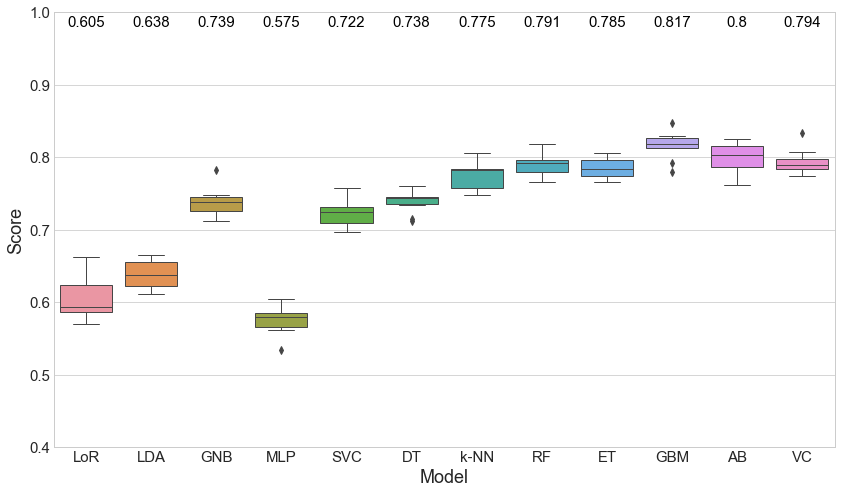

Populating the interactive namespace from numpy and matplotlib


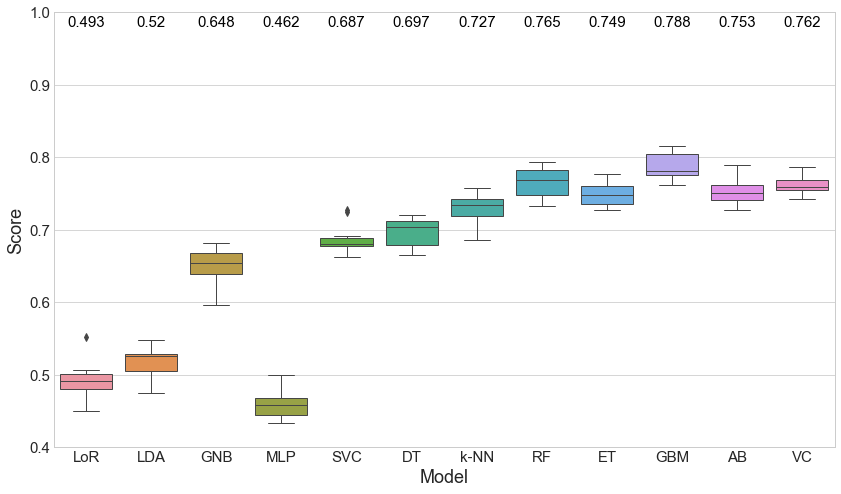

Populating the interactive namespace from numpy and matplotlib


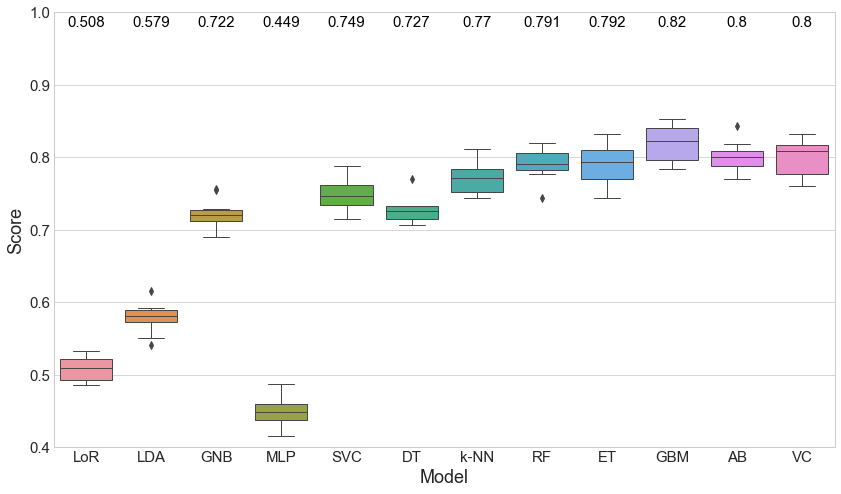

Populating the interactive namespace from numpy and matplotlib


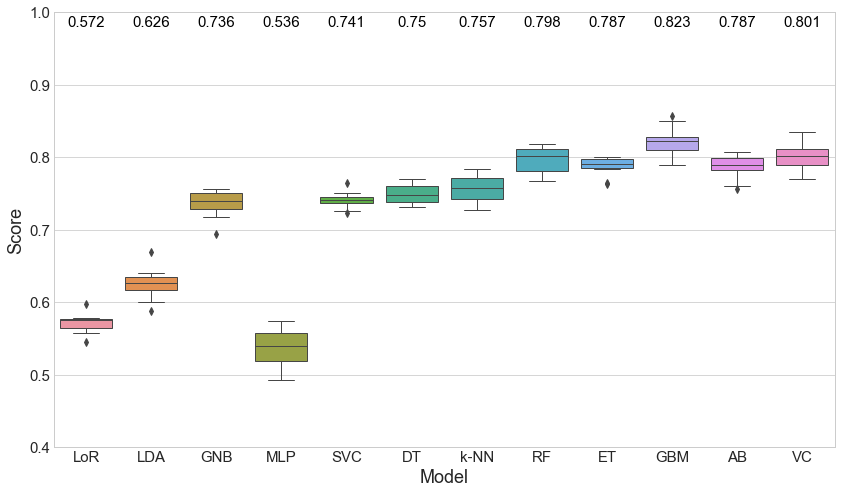

Populating the interactive namespace from numpy and matplotlib


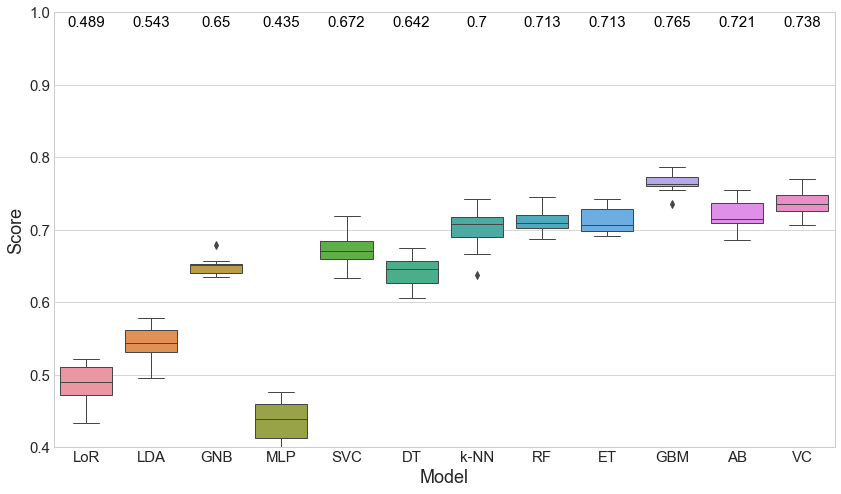

Populating the interactive namespace from numpy and matplotlib


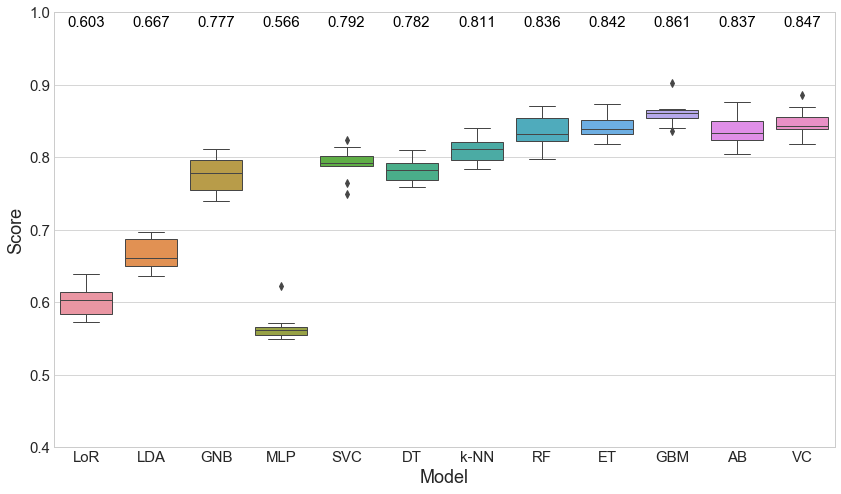

In [19]:
for i in range(6):
    column_boxplot(pd.DataFrame(salida[i]), 'values', "accuracy_Tx0"+str(i+1))

## Error Boxplot Simetrico

Populating the interactive namespace from numpy and matplotlib


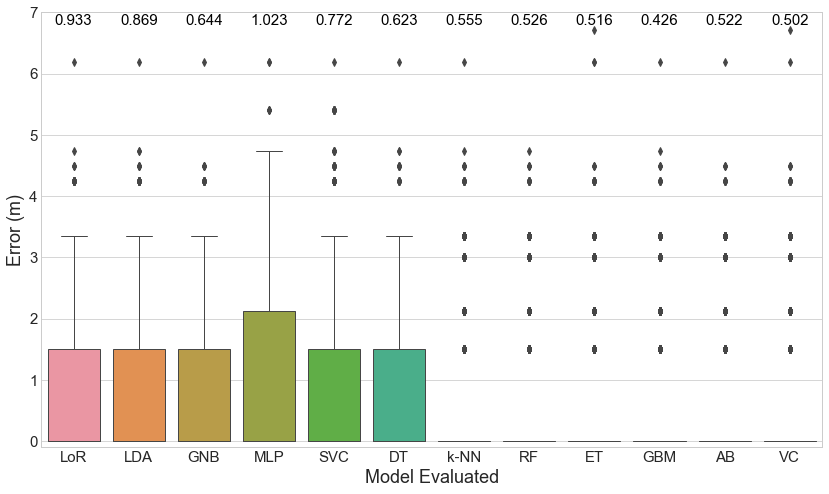

Populating the interactive namespace from numpy and matplotlib


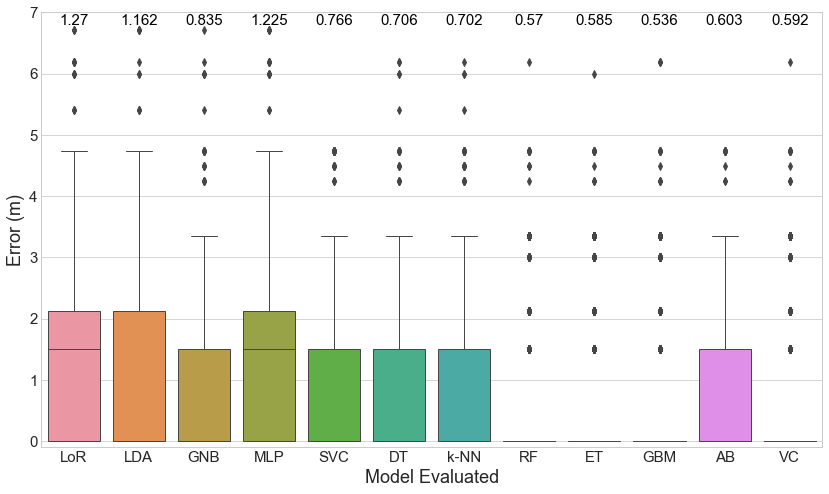

Populating the interactive namespace from numpy and matplotlib


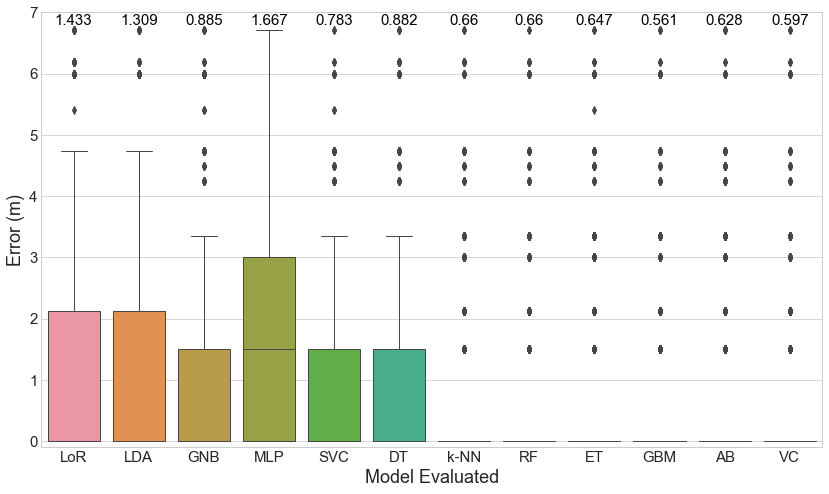

Populating the interactive namespace from numpy and matplotlib


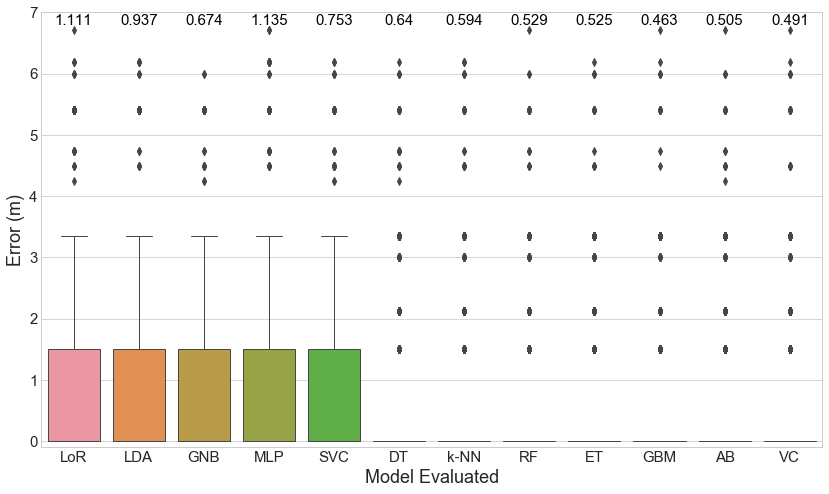

Populating the interactive namespace from numpy and matplotlib


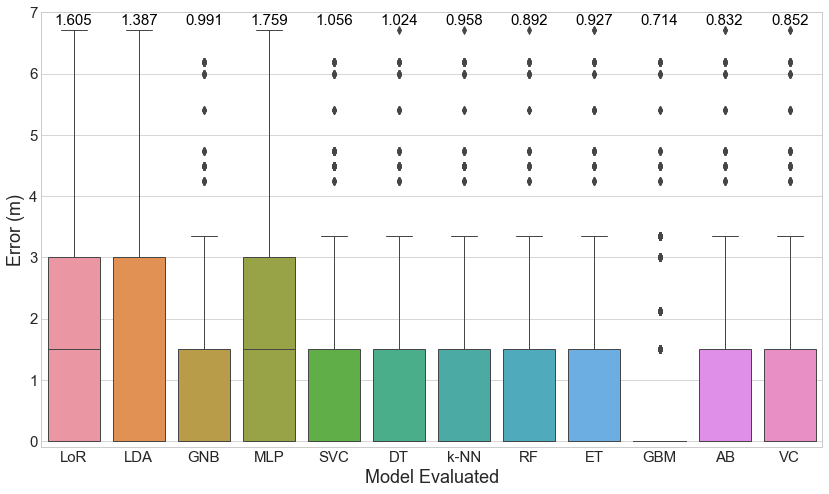

Populating the interactive namespace from numpy and matplotlib


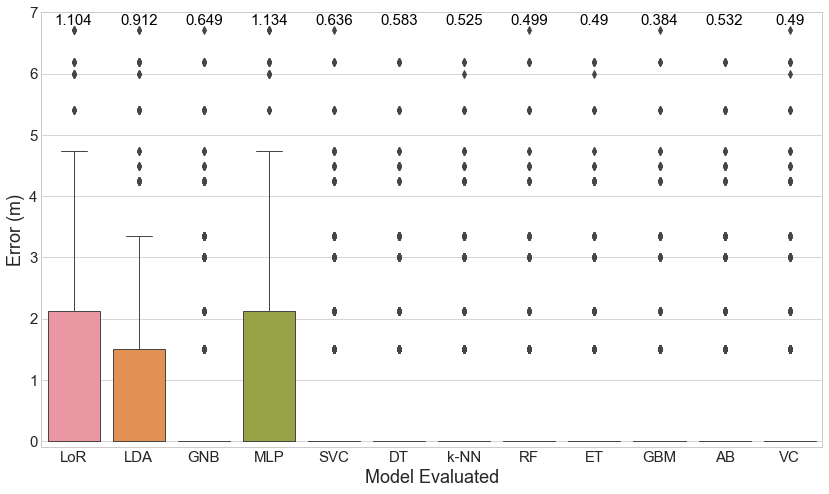

In [18]:
for i in range(6):
    column_boxplot(pd.DataFrame(salida[i]), 'error', "error_boxplot_Tx0"+str(i+1))

## Error Barplot Simetrico

Populating the interactive namespace from numpy and matplotlib


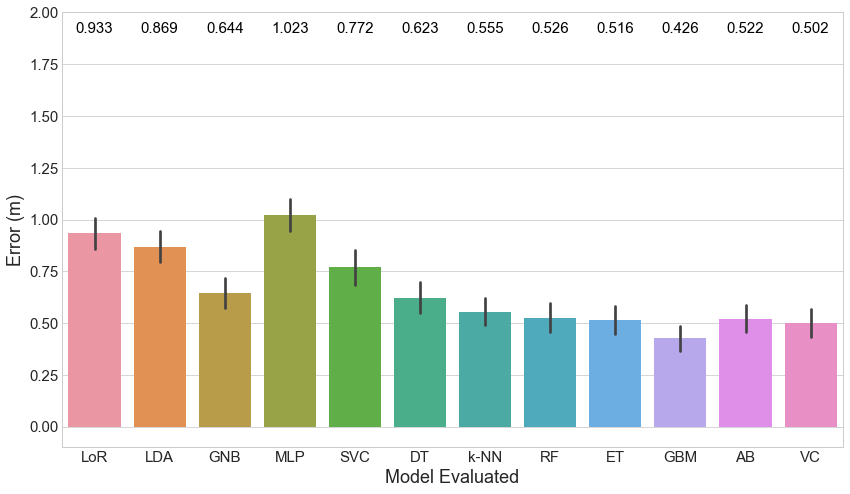

Populating the interactive namespace from numpy and matplotlib


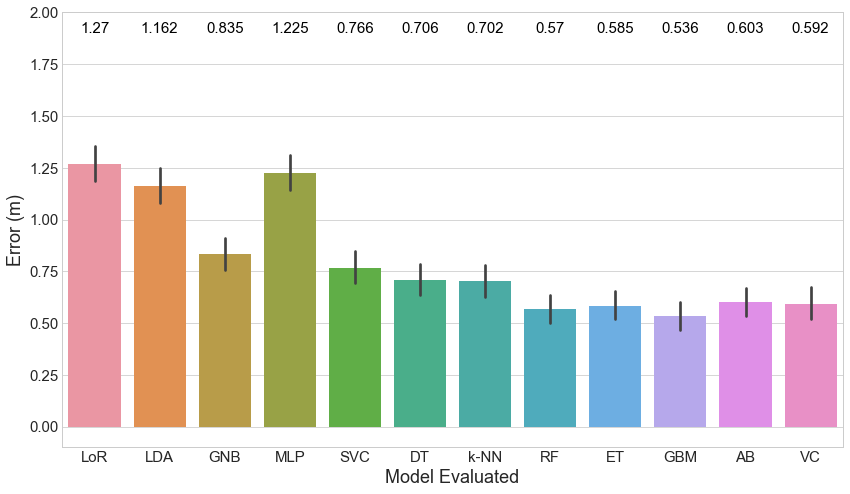

Populating the interactive namespace from numpy and matplotlib


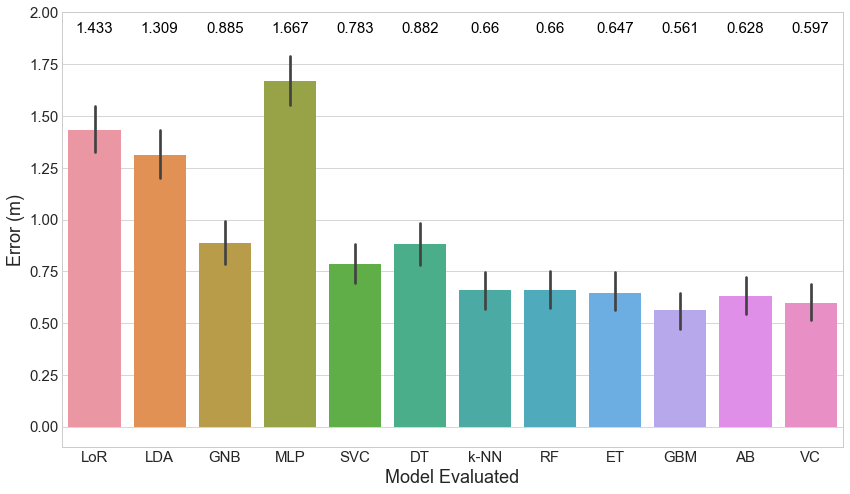

Populating the interactive namespace from numpy and matplotlib


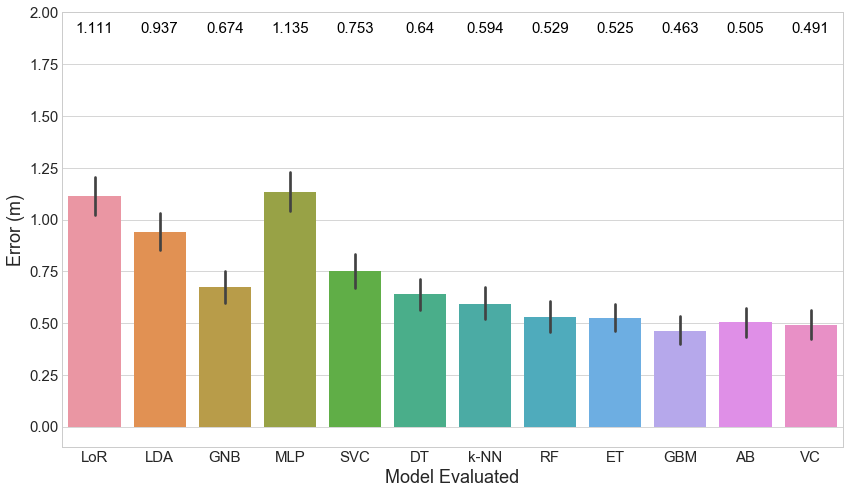

Populating the interactive namespace from numpy and matplotlib


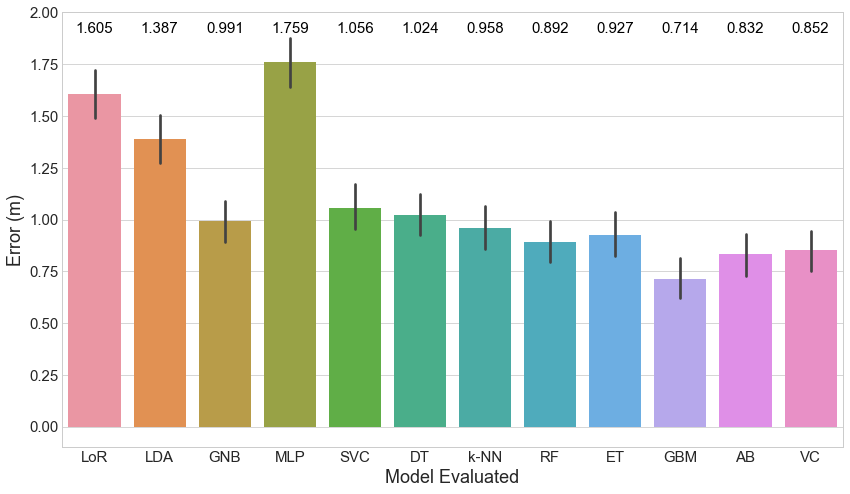

Populating the interactive namespace from numpy and matplotlib


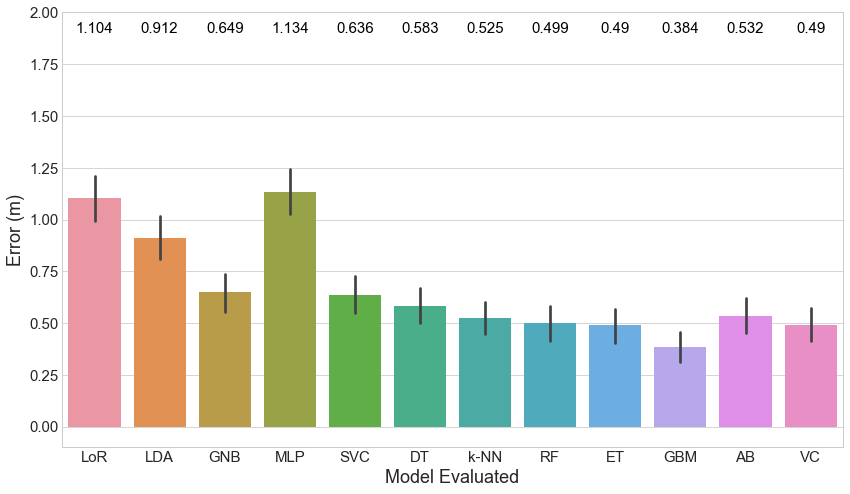

In [20]:
for i in range(6):
    column_boxplot(pd.DataFrame(salida[i]), 'error', "error_barplot_Tx0"+str(i+1), box_bool=False)

In [20]:
topDf = pd.DataFrame(test_cache).sort_values(['Accuracy'],ascending=False).drop_duplicates(subset=['Modelo'])
topDf[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']].to_csv('Top_simetricos.csv', sep=',', index=False) 
display(topDf[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
65,GradientBoostingClassifier,"[6, 6, 6, 6, 6]",0.860644,0.017146,0.383523
71,VotingClassifier,"[6, 6, 6, 6, 6]",0.846825,0.018994,0.489546
47,ExtraTreesClassifier,"[6, 6, 6, 6, 6]",0.842062,0.016526,0.489539
53,AdaBoostClassifier,"[6, 6, 6, 6, 6]",0.836589,0.021882,0.531960
59,RandomForestClassifier,"[6, 6, 6, 6, 6]",0.836122,0.022601,0.498649
29,KNeighborsClassifier,"[6, 6, 6, 6, 6]",0.810628,0.017855,0.525110
11,SVC,"[6, 6, 6, 6, 6]",0.791816,0.020481,0.635627
35,DecisionTreeClassifier,"[6, 6, 6, 6, 6]",0.781560,0.015619,0.582559
17,GaussianNB,"[6, 6, 6, 6, 6]",0.777047,0.022822,0.648710
5,LinearDiscriminantAnalysis,"[6, 6, 6, 6, 6]",0.666508,0.020948,0.911977
